In [1]:
import os
import sys
import struct
import random
import subprocess

import m2cgen as m2c
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN, KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import least_squares
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


sys.path.append("../sensor-road-type-recognition-code_optim_dev/script")
from road_event_detection import get_df_win_feature


pd.set_option('display.width', 100000)
pd.set_option('display.max_rows', 100000)
pd.set_option('display.max_columns', 100000)
pd.set_option('max_colwidth', 100000)

In [2]:
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import time
from sklearn.utils import shuffle
import scipy.stats as st
from sklearn.ensemble import RandomForestClassifier

# Load data

In [3]:
def log_data1(root_path):
    '''用于DataRecordInput_20230710_155650_上桥_19117.csv这种格式'''
    label_map={'上桥':1,'下桥':2,'减速带':3,'颠簸':4}
    
    data=[]
    for folder in tqdm(os.listdir(root_path),bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}'):
        if '.DS_Store' in folder or 'ipynb_checkpoints' in folder:continue                         
        folder_path=os.path.join(root_path,folder)
        for file in os.listdir(folder_path):
            if not 'csv' in file:continue
            file_path=os.path.join(folder_path,file)
            datum=pd.read_csv(file_path).iloc[0:600]               #读取滑窗数据
            label=label_map[file.split('_')[3]]                    #获取标签
            datum=pd.Series(get_df_win_feature(datum))             #生成特征
            datum['label']=label
            data.append(datum)   
    data=pd.DataFrame(data)
    return data

def log_data2(root_path):
    '''用于DataRecordInput_20230710_160621_21217_1.csv这种格式'''
    
    data=[]
    for file in tqdm(os.listdir(root_path),bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}'):
        if not 'csv' in file:continue
        file_path=os.path.join(root_path,file)
        datum=pd.read_csv(file_path).iloc[0:600]                   #读取滑窗数据
        label=int(file.replace(".csv", "").split("_")[-1])         #获取标签
        datum=pd.Series(get_df_win_feature(datum))                 #生成特征
        datum['label']=label
        data.append(datum)     
    data=pd.DataFrame(data)
    return data

def log_data3(root_path):
    """用于读取伪标签数据"""
    label_map={'上桥':1,'下桥':2,'减速带':3,'颠簸':4}
    
    data=[]
    for file in tqdm(os.listdir(root_path),bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}'):
        if not 'csv' in file:continue
        file_path=os.path.join(root_path,file)
        datum=pd.read_csv(file_path).iloc[0:600]                   #读取滑窗数据
        if datum.shape[0]==0:continue                              #跳过空数据
        label=label_map[file.split('_')[3]]                        #获取标签
        datum=pd.Series(get_df_win_feature(datum))                 #生成特征
        datum['label']=label
        data.append(datum)  
    data=pd.DataFrame(data)
    return data

root1='处理后的数据'
root2='marked_4d_df_win_new'
root_unlabeled='处理后的数据_unlabeled'

data_labeled=shuffle(pd.concat([log_data1(root1),log_data2(root2)],ignore_index=True))
data_unlabeled=shuffle(log_data3(root_unlabeled))

data_labeled.fillna(data_labeled.mean(),inplace=True)
data_unlabeled.fillna(data_unlabeled.mean(),inplace=True)

100%|██████████| 1883/1883 [03:55<00:00,  8.01it/s]                                                                                                                                            


In [4]:
print(data_labeled.shape)
print(data_unlabeled.shape)

(500, 2333)
(1879, 2333)


In [5]:
print('Labeled Dataset:\n',data_labeled['label'].value_counts().sort_index())
print('Initial Pseudo Labeled Dataset:\n',data_unlabeled['label'].value_counts().sort_index())

Labeled Dataset:
 0.0    144
1.0     71
2.0     75
3.0     66
4.0    144
Name: label, dtype: int64
Initial Pseudo Labeled Dataset:
 1.0     240
2.0     243
3.0      37
4.0    1359
Name: label, dtype: int64


# T-sne

In [27]:
from sklearn.preprocessing import StandardScaler
import plotly.express as px
from sklearn.manifold import TSNE

In [36]:
#Scaling-Scale to apply t-sne
standardscaler = StandardScaler()
tmp=deepcopy(data_unlabeled)
tmp['label']=-1
data_mixed=pd.concat([data_labeled,tmp],ignore_index=True)
X_scaled=standardscaler.fit_transform(data_mixed.loc[:,data_mixed.columns!='label'])
y=data_mixed['label'].astype(str)

In [34]:
print('Training {}...'.format('t-SNE'))
start_time=time.time()
tsne = TSNE(n_components=3, verbose=0, perplexity=30, n_iter=2000,n_jobs=-1,init='random')
tsne_results = tsne.fit_transform(X_scaled)
print('    Time Consumed:',round(time.time()-start_time),' second')
x_t,y_t,z_t=zip(*tsne_results)

Training t-SNE...
    Time Consumed: 21  second


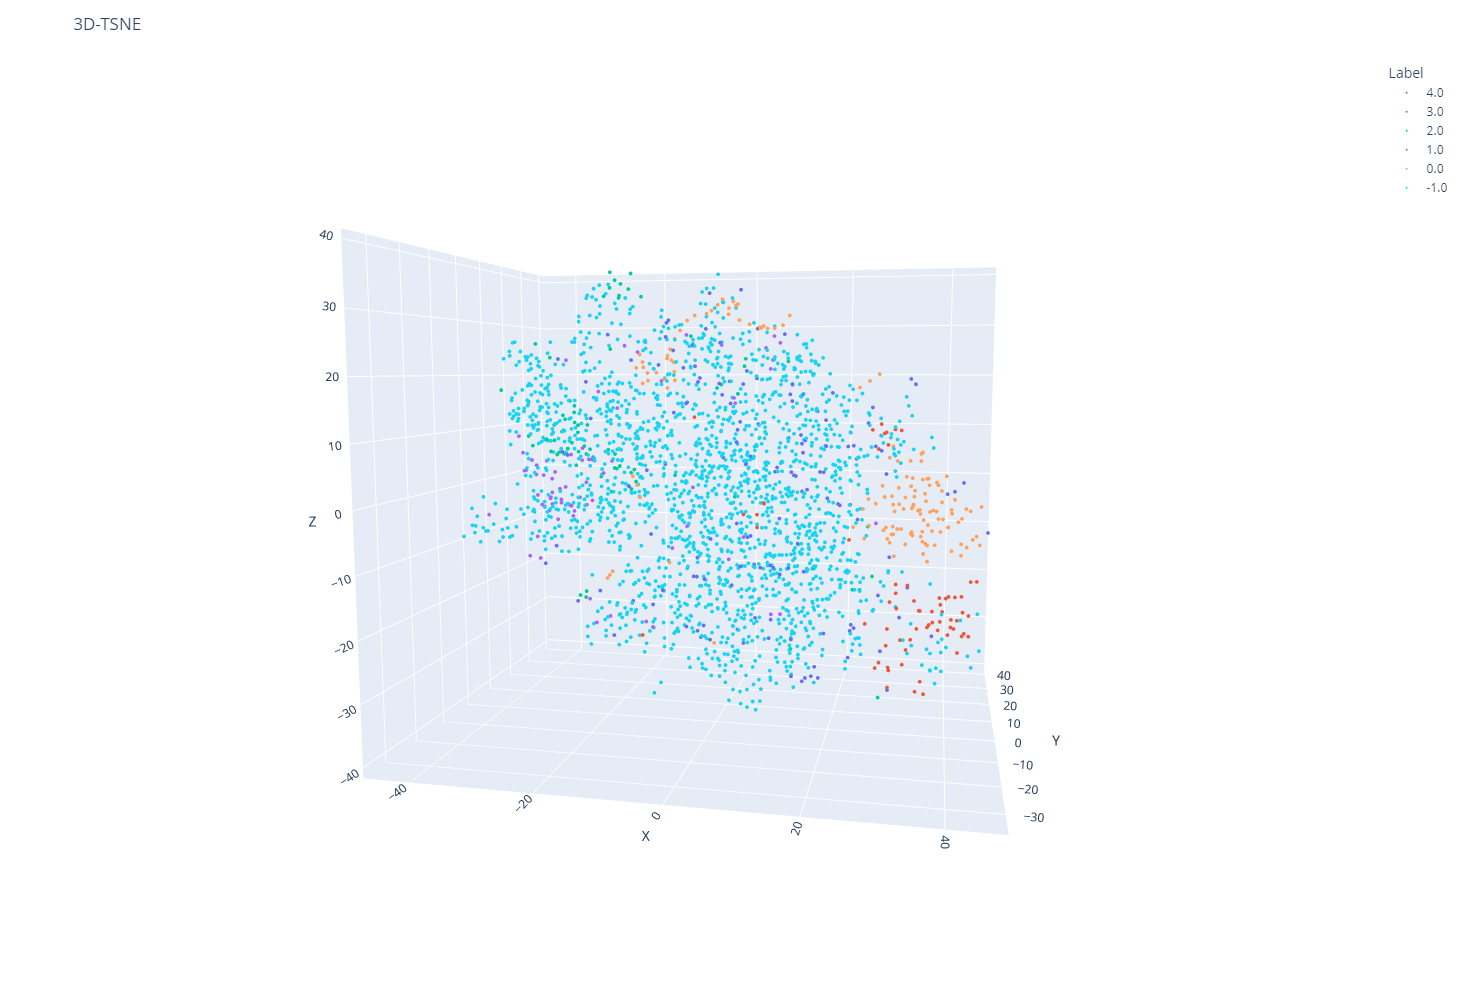

In [51]:
data_tmp=pd.DataFrame({'X':x_t,'Y':y_t,'Z':z_t,'Label':y})
fig=px.scatter_3d(data_frame=data_tmp.sort_values(by='Label',ascending=False),x='X',y='Y',z='Z',color='Label',width=1000,height=1000)
fig.update_traces(marker=dict(size=2))
fig.update_layout(
    title={'text': "3D-TSNE"})
fig.show()

# Performance Baseline on Labeled Data

In [7]:
X_train = data_labeled.iloc[:,:-1]
y_train = data_labeled.iloc[:,-1]

t=time.time()

model = XGBClassifier(
    n_estimators=100,
    max_depth=1,
    subsample=0.7,
    n_jobs=-1
)

from sklearn.model_selection import cross_val_score
scores=cross_val_score(model,X_train,y_train,scoring='accuracy',cv=100,n_jobs=-1)
print('Mean CV Scores:',np.mean(scores))
print('CV Score CI:',st.t.interval(alpha=0.95, df=len(scores)-1, loc=np.mean(scores), scale=st.sem(scores)))

print(f'Timed Consumed:{time.time()-t}s')

CV Scores: [0.8 0.8 1.  1.  1.  1.  0.8 0.8 1.  0.6 0.8 1.  0.6 0.8 1.  0.6 0.8 0.8
 0.6 0.8 0.8 0.8 0.6 1.  1.  0.8 1.  0.6 0.6 0.8 0.8 0.8 0.8 0.8 1.  1.
 0.6 0.6 0.8 0.6 1.  0.8 1.  0.8 1.  1.  0.6 0.6 1.  0.4 0.6 0.6 1.  0.6
 1.  0.8 1.  0.8 0.6 0.8 1.  1.  0.6 0.8 1.  0.6 0.8 0.8 0.8 0.8 0.8 1.
 1.  0.8 0.6 0.6 0.8 0.4 0.8 0.8 0.6 1.  0.6 0.6 1.  0.8 1.  0.8 0.6 0.8
 1.  1.  0.8 1.  0.8 0.8 0.8 1.  0.8 1. ]
Mean CV Scores: 0.81
CV Score CI: (0.7779061779465349, 0.8420938220534652)
Timed Consumed:22.078449249267578s


In [23]:
X_train = data_labeled.iloc[:,:-1]
y_train = data_labeled.iloc[:,-1]

t=time.time()

model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    n_jobs=-1,
    class_weight='balanced'
)

from sklearn.model_selection import cross_val_score
scores=cross_val_score(model,X_train,y_train,scoring='accuracy',cv=10,n_jobs=10)
print('CV Scores:',scores)
print('Mean CV Scores:',np.mean(scores))
print('CV Score CI:',st.t.interval(alpha=0.95, df=len(scores)-1, loc=np.mean(scores), scale=st.sem(scores)))

print(f'Timed Consumed:{time.time()-t}s')

CV Scores: [0.82 0.92 0.78 0.9  0.84 0.88 0.86 0.84 0.86 0.88]
Mean CV Scores: 0.858
CV Score CI: (0.8290302532847417, 0.8869697467152583)
Timed Consumed:0.5598239898681641s


# Adaptive Semi-supervised Learning

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score,recall_score,f1_score, accuracy_score
from copy import deepcopy
import multiprocessing as mp

class ASL:
    def __init__(self,data_labeled,data_unlabeled,model,scoring_metric='accuracy',
                 cv_folds=5,sampling_round=100,sampling_frac=0.01,performance_gain_threshold=0,seed=42,
                 pseudo_label_update_strategy='partial'):
        """
            data_labeled,data_unlabeled:pd.DataFrame with a col named 'label'
            model: model instance which has method .predict() & .fit()
            scoring_metric: ['accuracy','precision','recall','f1']
            cv_folds: number of folds in cv
            sampling_round: number of rounds for sampling_cv
            sampling_frac: frac of unlabeled data to sample in each sampling_cv
            performance_gain_threshold: avg sampling performance threshold to select added unlabeled data
            seed: random seed to use in augmented cv
            pseudo_label_update_strategy:['partial','all']
        """
        
        self.data_labeled=data_labeled                                                                #Labeled Data
        self.data_unlabeled=data_unlabeled                                                            #Unlabeled Data
        self.model=model                                                                              #Model to improve
        self.update_strategy=pseudo_label_update_strategy                                             #strategy for updating pseudo labels
        self.cv_folds=cv_folds                                                                        #number of folds in cv
        self.sampling_round=sampling_round                                                            #number of rounds for sampling_cv
        self.sampling_frac=sampling_frac                                                              #frac of unlabeled data to sample in each sampling_cv
        self.performance_gain_threshold=performance_gain_threshold                                    #avg sampling performance threshold to select added unlabeled data
        self.seed=seed                                                                                #random seed to use in augmented cv
        
        self.__metrics={'precision':precision_score,
                        'recall':recall_score,
                        'f1':f1_score,
                        'accuracy':accuracy_score}
        self.scoring_metric_name=scoring_metric
        self.scoring_metric_func=self.__metrics[scoring_metric]                                       #scoring metric function
        
        self.__cols=self.data_labeled.columns                                                         #colnames
        self.__n_data_unlabeled=self.data_unlabeled.shape[0]                                          #number of unlabeled data
        self.iter_info={'LabeledPerformance':[],'UnlabeledAdded':[[False]*self.__n_data_unlabeled],
                        'ActualUnlabeledPerformanceGain':[np.array([np.nan]*self.__n_data_unlabeled)],
                        'SamplingUnlabeledPerformanceGain':[np.array([np.nan]*self.__n_data_unlabeled)],
                        'PseudoLabels':[self.data_unlabeled['label'].to_numpy()],
                        'ModelCheckPoints':[]}
        
    def augmented_cv(self,data_unlabeled_added):
        """
            data_unlabeled_added:unlabeled data to use for this cv
        """
        #Split X,y from labeled & unlabeled data
        X_train_labeled,y_train_labeled=self.data_labeled.loc[:,self.__cols!='label'],self.data_labeled['label']
        X_fit_unlabeled,y_fit_unlabeled=data_unlabeled_added.loc[:,self.__cols!='label'],data_unlabeled_added['label']
        
        #Multiprocessing augmented cv
        cv_metrics=[]
        kf = StratifiedKFold(n_splits=self.cv_folds,shuffle=True,random_state=self.seed)    
        for fit_index, val_index in kf.split(X_train_labeled,y_train_labeled):
            X_fit_labeled, X_val_labeled = X_train_labeled.iloc[fit_index,:], X_train_labeled.iloc[val_index,:]
            y_fit_labeled, y_val_labeled = y_train_labeled.iloc[fit_index], y_train_labeled.iloc[val_index]

            X_fit_mixed=pd.concat([X_fit_labeled,X_fit_unlabeled],ignore_index=True)                 #merge added unlabeled data and labeled train data 
            y_fit_mixed=pd.concat([y_fit_labeled,y_fit_unlabeled],ignore_index=True)

            self.model.fit(X_fit_mixed,y_fit_mixed)
            y_val_pred=self.model.predict(X_val_labeled)
            cv_metric=self.scoring_metric_func(y_val_labeled,y_val_pred)
            cv_metrics.append(cv_metric)
        
        cv_metrics=np.mean(cv_metrics)
        return cv_metrics
    
    def unlabeled_sampling_cv(self):
        data_unlabeled_added_idx=np.argwhere(self.iter_info['UnlabeledAdded'][-1]).flatten()          #read selected unlabeled data from latest iter_info
        data_unlabeled_added=self.data_unlabeled.iloc[data_unlabeled_added_idx]
        
        pool_size=self.__n_data_unlabeled
        n=self.sampling_round
        frac=self.sampling_frac
        
        performance_gain=np.zeros((self.__n_data_unlabeled,))
        selected_count=np.zeros((self.__n_data_unlabeled,))
        for i in tqdm(range(n),bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}'):
            sampled_idx=random.choices(range(pool_size),k=int(frac*pool_size))                        #Sampling unlabeled data
            sampled_data_unlabeled=data_unlabeled.iloc[sampled_idx]
            
            cv_metrics=self.augmented_cv(sampled_data_unlabeled)
            performance_gain[sampled_idx]+=(cv_metrics-self.iter_info['LabeledPerformance'][-1])
            selected_count[sampled_idx]+=1
            
        (performance_gain[selected_count!=0])/=(selected_count[selected_count!=0])                    #calculate avg performance gain for selected unlabeled sample
        performance_gain[selected_count==0]=np.nan                                                    #mark the unlabaled sample which was never selected
        
        data_unlabeled_added_idx=np.array([False]*self.__n_data_unlabeled)
        data_unlabeled_added_idx[performance_gain>=self.performance_gain_threshold]=True
        self.iter_info['SamplingUnlabeledPerformanceGain'].append(np.array(performance_gain))         #save sampling performance gain for this iter
        self.iter_info['UnlabeledAdded'].append(np.array(data_unlabeled_added_idx))                   #update the unlabeled sample add status

        return True if sum(performance_gain>self.performance_gain_threshold)==0 else False            #Algorithm converged due to no more improvement

    def save_checkpoints(self,data_unlabeled_added):
        X_labeled,y_labeled=self.data_labeled.loc[:,self.__cols!='label'],self.data_labeled['label']
        X_unlabeled,y_unlabeled=data_unlabeled_added.loc[:,self.__cols!='label'],data_unlabeled_added['label']   
        X_mixed=pd.concat([X_labeled,X_unlabeled],ignore_index=True)
        y_mixed=pd.concat([y_labeled,y_unlabeled],ignore_index=True)
        self.model.fit(X_mixed,y_mixed)
        self.iter_info['ModelCheckPoints'].append(deepcopy(self.model))
        
    def evaluate_on_labeled(self):
        """Calculate the first cv performance without any unlabeled data"""
        data_unlabeled_added_idx=np.argwhere(self.iter_info['UnlabeledAdded'][-1]).flatten()          #read selected unlabeled data from latest iter_info
        data_unlabeled_added=self.data_unlabeled.iloc[data_unlabeled_added_idx]
        
        #Augmentated cross validation
        cv_metrics=self.augmented_cv(data_unlabeled_added)
        
        performance_gain=np.array([np.nan]*self.__n_data_unlabeled)
        performance_gain[data_unlabeled_added_idx]=cv_metrics-self.iter_info['LabeledPerformance'][0]  #calculate performance gain by comparing with the initial performance
        
        self.iter_info['LabeledPerformance'].append(cv_metrics)                                        #save the improved model performance for this iter
        self.iter_info['ActualUnlabeledPerformanceGain'].append(np.array(performance_gain))            #save the actual performance gain for this iter
        self.save_checkpoints(data_unlabeled_added)                                                    #Save model fitted with all labeled and added unlabeled data as checkpoints
        
        print(f'    {self.scoring_metric_name}:{cv_metrics}')
        
    def update_pseudo_label(self):
        """update pseudo labels with the latest model. Strategy can be partial, which only updates the sample whose performance gain is below the threshold, and all, which updates all the pseudo labels."""
        data_unlabeled_added_list=self.iter_info['UnlabeledAdded'][-1]                                 #read selected unlabeled data from latest iter_info
        data_unlabeled_added=self.data_unlabeled.loc[data_unlabeled_added_list]
        
        X_train_labeled,y_train_labeled=self.data_labeled.loc[:,self.__cols!='label'],self.data_labeled['label']
        X_train_unlabeled,y_train_unlabeled=data_unlabeled_added.loc[:,self.__cols!='label'],data_unlabeled_added['label']
        
        X_train=pd.concat([X_train_labeled,X_train_unlabeled],ignore_index=True)
        y_train=pd.concat([y_train_labeled,y_train_unlabeled],ignore_index=True)
         
        self.model.fit(X_train,y_train)                                                               #train model with labeled data & added unlabeled data
        
        #update pseudo label
        if self.update_strategy=='partial':
            self.data_unlabeled.loc[~data_unlabeled_added_list,'label']=self.model.predict(self.data_unlabeled.loc[~data_unlabeled_added_list,self.__cols!='label'])  #only update non-added unlabeled
        elif self.update_strategy=='all':
            self.data_unlabeled['label']=self.model.predict(self.data_unlabeled.loc[:,self.__cols!='label'])                                                          #update all unlabeled data
        
            
        self.iter_info['PseudoLabels'].append(np.array(self.data_unlabeled['label']))                 #save pseudo labels for this iter
        
        return True if all(self.data_unlabeled['label']==self.iter_info['PseudoLabels'][-2]) else False  #Algorithm might converge due to no update on peusdo labels
    
    def main(self,epoch):
        #Initial Performance on labeled data, without any added unlabeled data
        print('Initializing...\n')
        data_unlabeled_placeholder=pd.DataFrame(None,columns=self.__cols)
        self.iter_info['LabeledPerformance'].append(self.augmented_cv(data_unlabeled_placeholder)) 
        self.save_checkpoints(data_unlabeled_placeholder)
        print('    ',self.scoring_metric_name,'Baseline:',self.iter_info['LabeledPerformance'][-1])
        
        for i in range(epoch):
            print(f'\nEpoch{i}------------------------------------------------------------------------')
            print('Sampling CV...')
            converged=self.unlabeled_sampling_cv()
            if converged:
                print('ASL Converged')
                break
            print('Evaluating...')
            self.evaluate_on_labeled()
            print('Updating Pseudo labels...')
            pseudo_labels_unchange=self.update_pseudo_label()
            if pseudo_labels_unchange:print('    Pseudo Labels Unchanged')
        if not converged:print('\nEpoch Ends')
        
        return self.iter_info
    
#model=XGBClassifier(n_estimators=100,max_depth=1,subsample=0.7,n_jobs=-1,random_state=42)
model=RandomForestClassifier(n_estimators=100,max_depth=5,n_jobs=-1,random_state=42,class_weight='balanced')
test=ASL(data_labeled,data_unlabeled,model=model,scoring_metric='accuracy',pseudo_label_update_strategy='partial',performance_gain_threshold=-0.02)
res=test.main(epoch=10)

Initializing...

     accuracy Baseline: 0.828

Epoch0------------------------------------------------------------------------
Sampling CV...


100%|██████████| 100/100 [02:38<00:00,  1.58s/it]                                                                                                                                              


Evaluating...
    accuracy:0.764
Updating Pseudo labels...
    Pseudo Labels Unchanged

Epoch1------------------------------------------------------------------------
Sampling CV...


100%|██████████| 100/100 [02:32<00:00,  1.52s/it]                                                                                                                                              


Evaluating...
    accuracy:0.7939999999999999
Updating Pseudo labels...

Epoch2------------------------------------------------------------------------
Sampling CV...


100%|██████████| 100/100 [02:33<00:00,  1.54s/it]                                                                                                                                              


Evaluating...
    accuracy:0.7959999999999999
Updating Pseudo labels...

Epoch3------------------------------------------------------------------------
Sampling CV...


100%|██████████| 100/100 [02:32<00:00,  1.52s/it]                                                                                                                                              


Evaluating...
    accuracy:0.804
Updating Pseudo labels...

Epoch4------------------------------------------------------------------------
Sampling CV...


100%|██████████| 100/100 [02:32<00:00,  1.53s/it]                                                                                                                                              


Evaluating...
    accuracy:0.8140000000000001
Updating Pseudo labels...

Epoch5------------------------------------------------------------------------
Sampling CV...


100%|██████████| 100/100 [02:32<00:00,  1.53s/it]                                                                                                                                              


Evaluating...
    accuracy:0.8019999999999999
Updating Pseudo labels...

Epoch6------------------------------------------------------------------------
Sampling CV...


100%|██████████| 100/100 [02:31<00:00,  1.52s/it]                                                                                                                                              


Evaluating...
    accuracy:0.806
Updating Pseudo labels...

Epoch7------------------------------------------------------------------------
Sampling CV...


100%|██████████| 100/100 [02:32<00:00,  1.53s/it]                                                                                                                                              


Evaluating...
    accuracy:0.812
Updating Pseudo labels...

Epoch8------------------------------------------------------------------------
Sampling CV...


100%|██████████| 100/100 [02:35<00:00,  1.56s/it]                                                                                                                                              


Evaluating...
    accuracy:0.8080000000000002
Updating Pseudo labels...

Epoch9------------------------------------------------------------------------
Sampling CV...


100%|██████████| 100/100 [02:34<00:00,  1.54s/it]                                                                                                                                              


Evaluating...
    accuracy:0.7979999999999999
Updating Pseudo labels...

Epoch Ends


100%|██████████| 11/11 [00:00<00:00, 216.19it/s]                                                                                                                                               


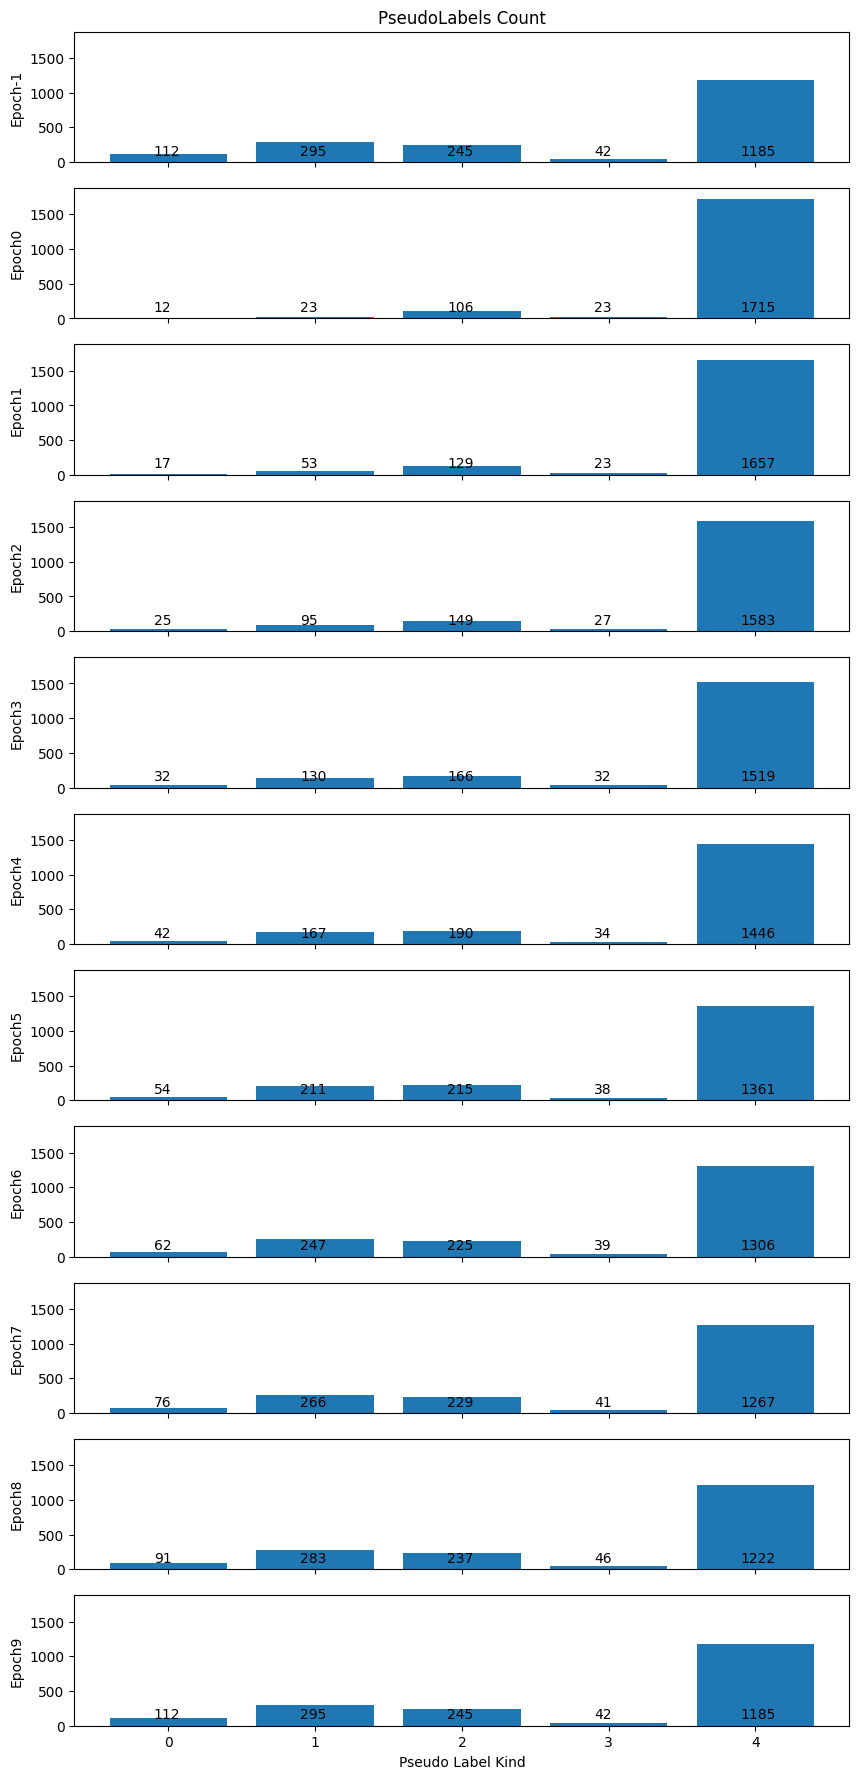

In [20]:
def show_pseudo_labels_count(iter_info):
    key='PseudoLabels'
    
    history=iter_info[key]
    n_unlabeled=len(iter_info[key][0])
    
    figure,axes=plt.subplots(len(history),1,figsize=(10,len(history)*2),sharex=True)
    axes=axes.flatten()
    for i in tqdm(range(len(history)),bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}'):
        count=pd.Series(history[i]).value_counts().sort_index()
        axes[i].bar(count.index,count.values)
        axes[i].set_ylim(0,n_unlabeled)
        axes[i].set_ylabel(f'Epoch{i-1}')
        for j in range(len(count)):axes[i].text(j-0.1,100,count[j])
    axes[0].set_title(key+' Count')
    axes[-1].set_xlabel('Pseudo Label Kind')
    plt.show()
    
    plt.show()
    
show_pseudo_labels_count(test.iter_info)

100%|██████████| 11/11 [00:11<00:00,  1.05s/it]                                                                                                                                                


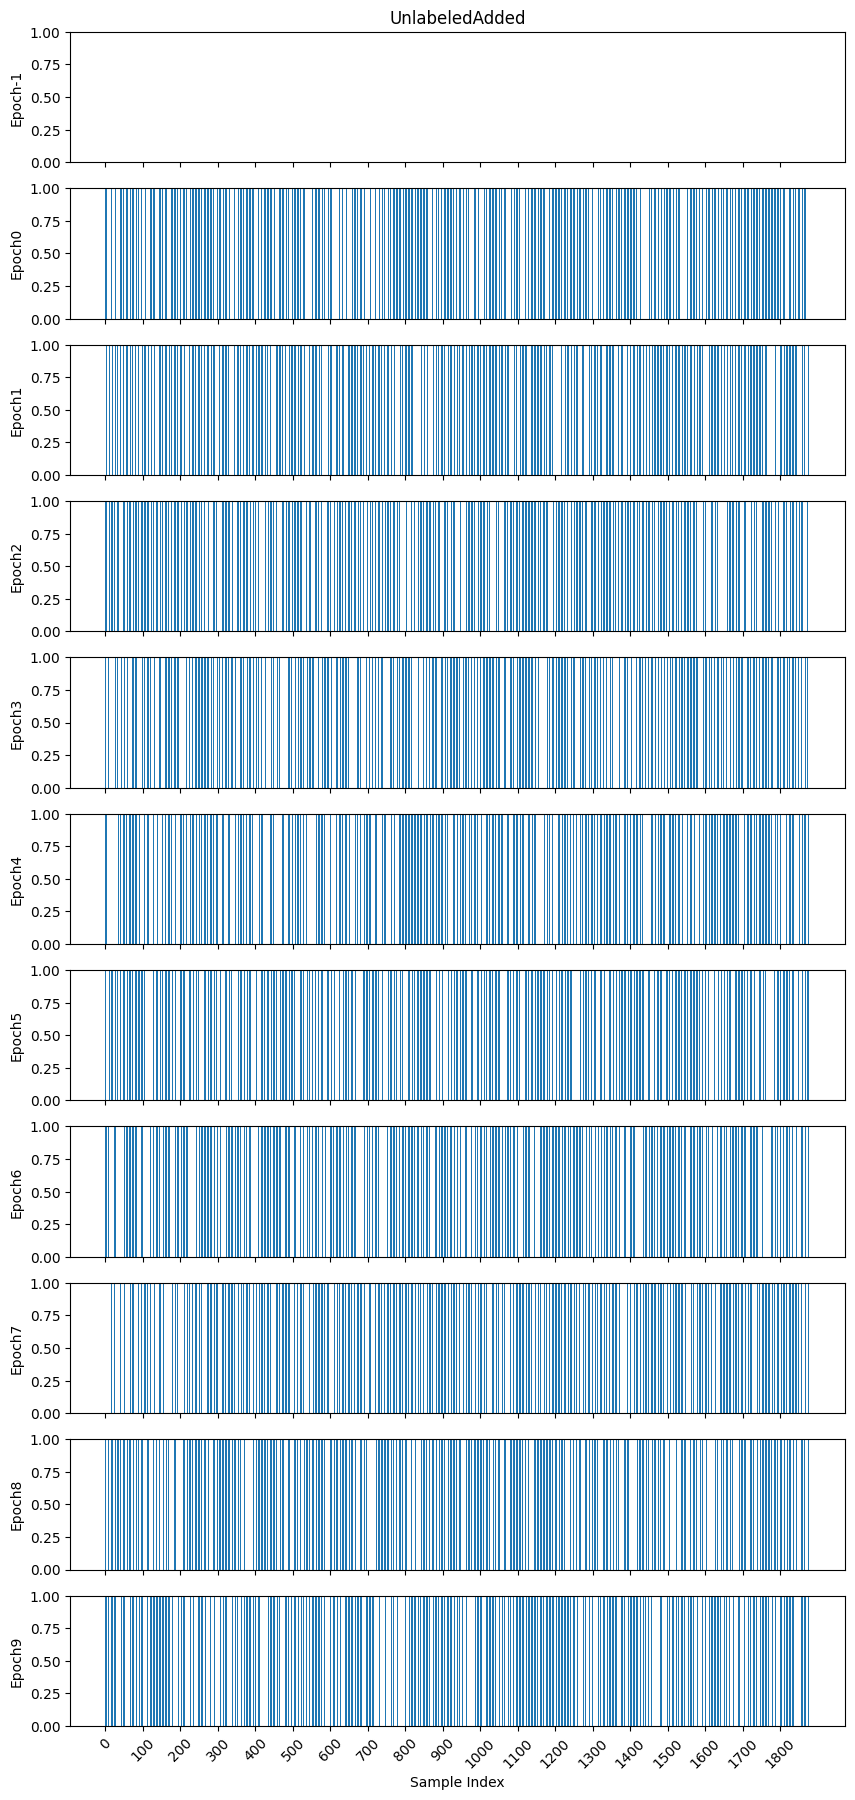

In [19]:
def show_unlabeled_added_status(iter_info):
    ylim=(0,1)
    func=int
    key='UnlabeledAdded'

    history=iter_info[key]
    n_unlabeled=len(history[0])
    
    figure,axes=plt.subplots(len(history),1,figsize=(10,len(history)*2),sharex=True)
    axes=axes.flatten()
    for i in tqdm(range(len(history)),bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}'):
        axes[i].bar(list(range(n_unlabeled)),list(map(func,history[i])))
        axes[i].set_ylim(*ylim)
        axes[i].set_ylabel(f'Epoch{i-1}')
    axes[0].set_title(key)
    axes[-1].set_xticks(list(range(0,n_unlabeled,100)),list(range(0,n_unlabeled,100)),rotation=45)
    axes[-1].set_xlabel('Sample Index')
    plt.show()

show_unlabeled_added_status(test.iter_info)

100%|██████████| 11/11 [00:10<00:00,  1.04it/s]                                                                                                                                                


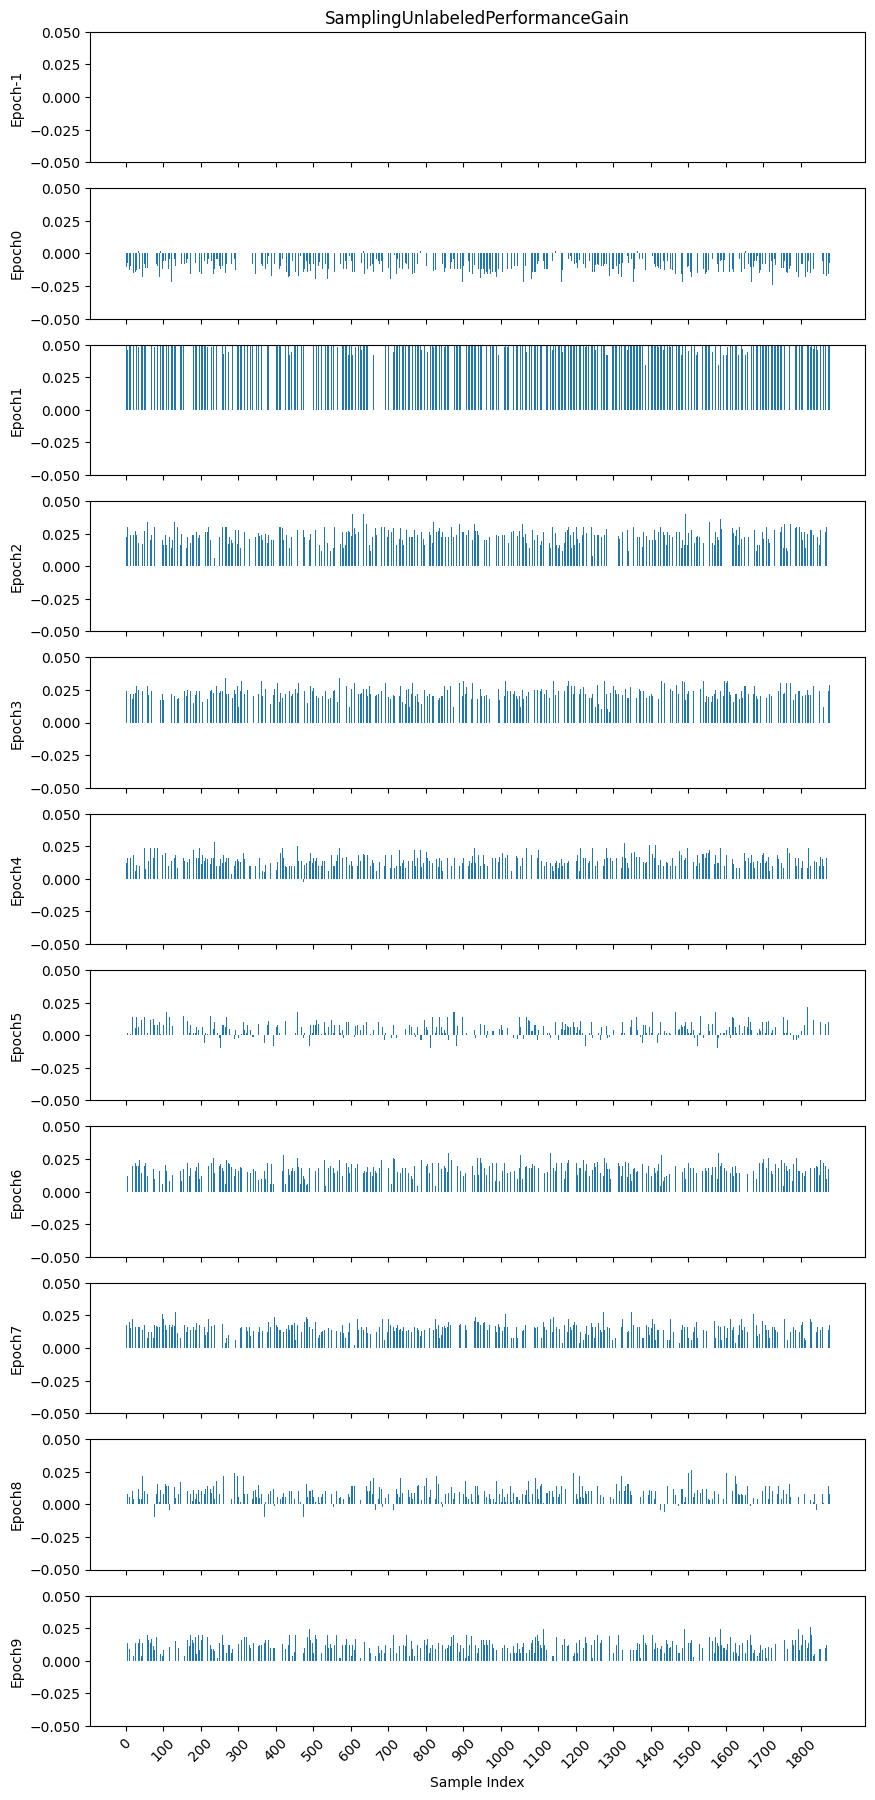

In [17]:
def show_unlabeled_samplingPerformanceGain(iter_info):
    ylim=(-0.05,0.05)
    func=lambda x:x
    key='SamplingUnlabeledPerformanceGain'

    history=iter_info[key]
    n_unlabeled=len(history[0])
    
    figure,axes=plt.subplots(len(history),1,figsize=(10,len(history)*2),sharex=True)
    axes=axes.flatten()
    for i in tqdm(range(len(history)),bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}'):
        axes[i].bar(list(range(n_unlabeled)),list(map(func,history[i])))
        axes[i].set_ylim(*ylim)
        axes[i].set_ylabel(f'Epoch{i-1}')
    axes[0].set_title(key)
    axes[-1].set_xticks(list(range(0,n_unlabeled,100)),list(range(0,n_unlabeled,100)),rotation=45)
    axes[-1].set_xlabel('Sample Index')
    plt.show()

show_unlabeled_samplingPerformanceGain(test.iter_info)

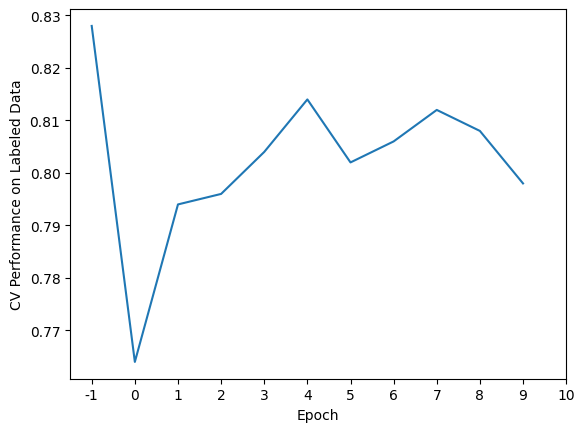

In [16]:
def show_unlabeled_samplingPerformanceGain(iter_info):
    key='LabeledPerformance'
    n_epochs=len(iter_info[key])
    plt.plot(list(range(-1,n_epochs-1)),iter_info[key])
    plt.xticks(list(range(-1,n_epochs)),list(range(-1,len(iter_info[key]))))
    plt.xlabel('Epoch')
    plt.ylabel('CV Performance on Labeled Data')
    plt.show()

show_unlabeled_samplingPerformanceGain(test.iter_info)

100%|██████████| 11/11 [00:11<00:00,  1.09s/it]                                                                                                                                                


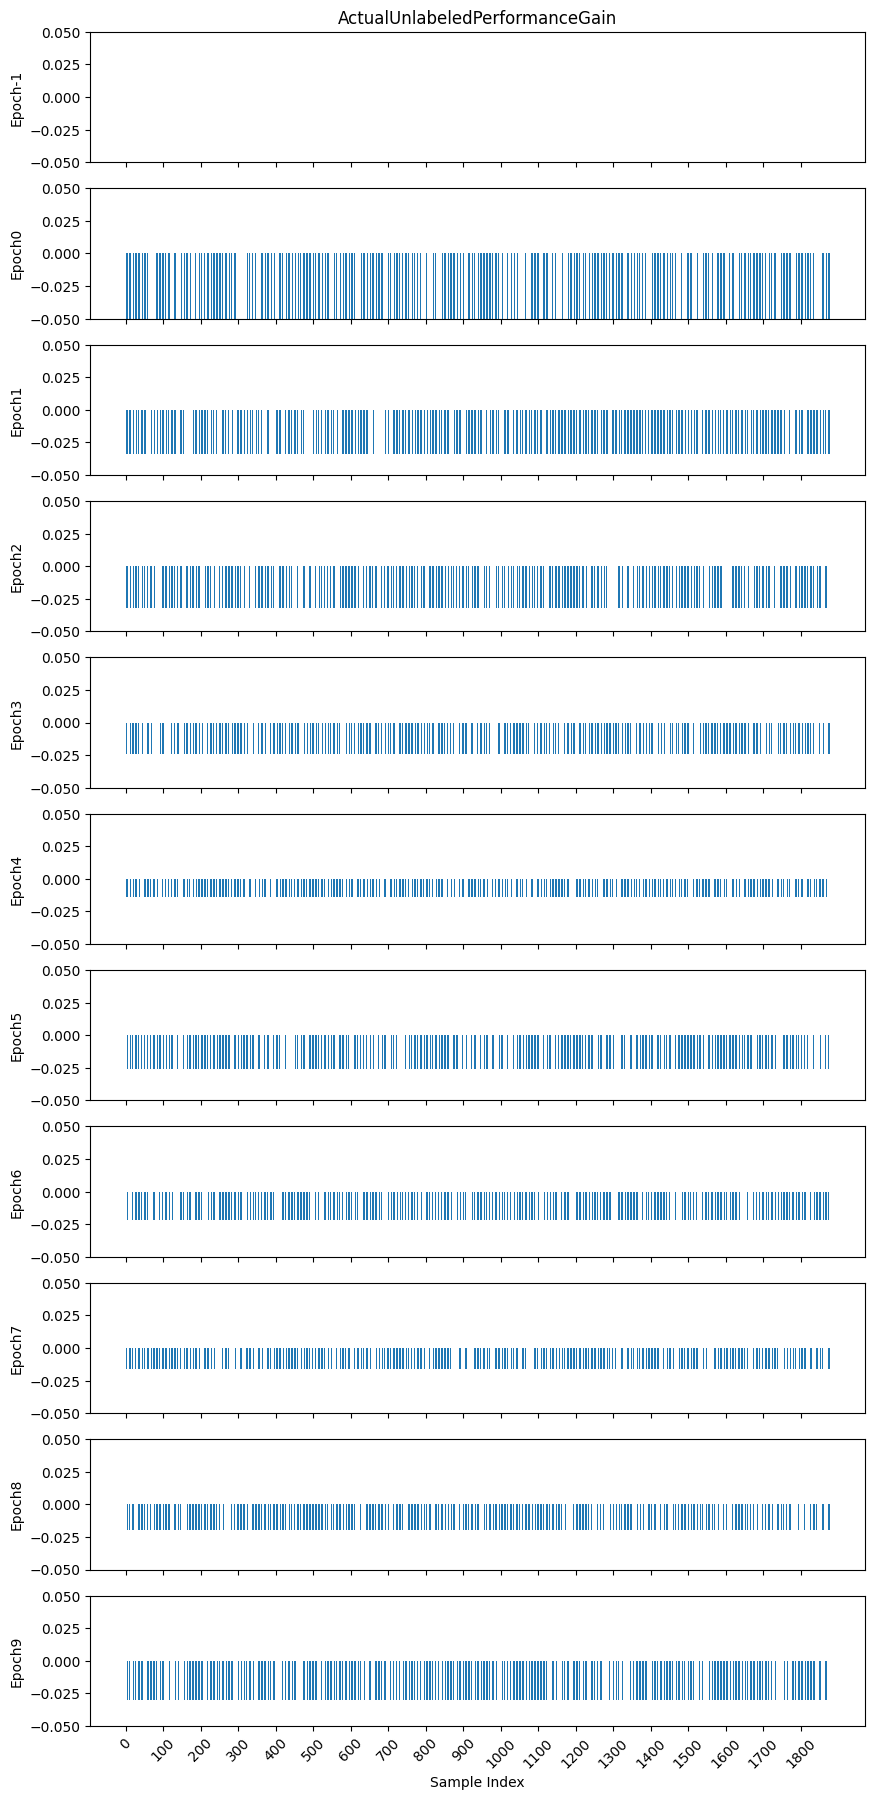

In [18]:
def show_unlabeled_samplingPerformanceGain(iter_info):
    ylim=(-0.05,0.05)
    func=lambda x:x
    key='ActualUnlabeledPerformanceGain'

    history=iter_info[key]
    n_unlabeled=len(history[0])
    
    figure,axes=plt.subplots(len(history),1,figsize=(10,len(history)*2),sharex=True)
    axes=axes.flatten()
    for i in tqdm(range(len(history)),bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}'):
        axes[i].bar(list(range(n_unlabeled)),list(map(func,history[i])))
        axes[i].set_ylim(*ylim)
        axes[i].set_ylabel(f'Epoch{i-1}')
    axes[0].set_title(key)
    axes[-1].set_xticks(list(range(0,n_unlabeled,100)),list(range(0,n_unlabeled,100)),rotation=45)
    axes[-1].set_xlabel('Sample Index')
    plt.show()

show_unlabeled_samplingPerformanceGain(test.iter_info)

In [43]:
test.iter_info['ModelCheckPoints']

[RandomForestClassifier(max_depth=5, n_jobs=-1, random_state=42),
 RandomForestClassifier(max_depth=5, n_jobs=-1, random_state=42),
 RandomForestClassifier(max_depth=5, n_jobs=-1, random_state=42),
 RandomForestClassifier(max_depth=5, n_jobs=-1, random_state=42),
 RandomForestClassifier(max_depth=5, n_jobs=-1, random_state=42),
 RandomForestClassifier(max_depth=5, n_jobs=-1, random_state=42),
 RandomForestClassifier(max_depth=5, n_jobs=-1, random_state=42),
 RandomForestClassifier(max_depth=5, n_jobs=-1, random_state=42),
 RandomForestClassifier(max_depth=5, n_jobs=-1, random_state=42),
 RandomForestClassifier(max_depth=5, n_jobs=-1, random_state=42),
 RandomForestClassifier(max_depth=5, n_jobs=-1, random_state=42)]

In [49]:
#check 
model=test.iter_info['ModelCheckPoints'][-1]
(model.predict(data_labeled.iloc[:,:-1])==data_labeled.iloc[:,-1]).value_counts()

True     481
False     19
Name: label, dtype: int64